# Intel Image Classification

## Step 0: import dataset from Kaggle

The dataset "Intel Image Classification" is used for this project

Here is the link for it: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

To import the chosen dataset from Kaggle, we need to perform the following steps:

1. Import the library for working with files in Google Colab.

In [2]:
from google.colab import files # library for working with files

ModuleNotFoundError: No module named 'google.colab'

2. Next, we need upload the kaggle.json file from local machine to Google Colab. This file is used to authenticate access to the Kaggle platform and allows to interact with Kaggle's datasets.
3. After uploading the file, we need install Kaggle API client, which allows to interact with Kaggle within Colab.

In [ ]:
files.upload() # upload kaggle.json from pc

!pip install -q kaggle # install kaggle API client

4. The folder with name ".kaggle" is created in the root directory to store kaggle.json
5. kaggle.json is moved to the created folder.
6. Set the permissions of file to ensure its security.

In [ ]:
! mkdir ~/.kaggle # create folder with name .kaggle
! cp kaggle.json ~/.kaggle/ # move kaggle.json to created directory
! chmod 600 /root/.kaggle/kaggle.json # change permissions to more secure

7. Download the dataset from Kaggle

In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

8. The unzip command may produce a lengthy output. To keep the cell output clean, we can use the magic command %%capture, which suppresses the output of the cell.
9. For storing images, director "image_files" is created.
10. Unzip the "intel-image-classification.zip" file into the "/content/image_files/" directory

In [ ]:
# for not showing output
%%capture
! mkdir /content/image_files
! unzip intel-image-classification.zip -d /content/image_files

## Step 1: explore the dataset

First, we need explore the dataset.

Let's import all the necessary libraries for this step.

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

Then let's create dataframe which contain information about each image, such as file name, label and category.

For doing this, we iterate over the items in the labels. After we traverse though folder with name of given label, and add information about each image to created dataframe.

In [3]:
root_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
sub_folders = os.listdir(root_dir)
labels = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4,
          'street': 5}

data = []

for s, l in labels.items():
      for r, d, f in os.walk(root_dir + s):
              for file in f:
                      if ".jpg" in file:
                          data.append((os.path.join(s,file), l, s))

df_images_info = pd.DataFrame(data, columns=['file_name', 'label', 'category'])

In [4]:
df_images_info.head()

,file_name,label,category
0,buildings/2193.jpg,0,buildings
1,buildings/11378.jpg,0,buildings
2,buildings/10730.jpg,0,buildings
3,buildings/17338.jpg,0,buildings
4,buildings/16730.jpg,0,buildings


Let's check how many images we have.

In [9]:
df_images_info.shape

(14034, 3)

The dataset contains 14 034 images.

Text(0.5, 1.0, 'Amount of images in each category')

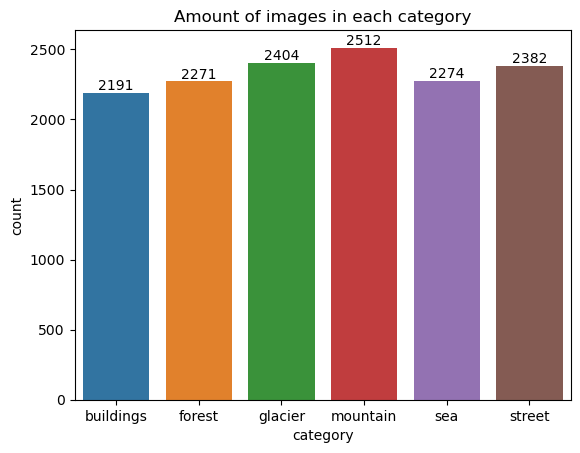

In [10]:
ax = sns.countplot(data=df_images_info, x='category')
ax.bar_label(ax.containers[0])
ax.set_title("Amount of images in each category")

As we can see, the dataset is pretty balanced.

To better understand the dataset, let's plot examples from each category.

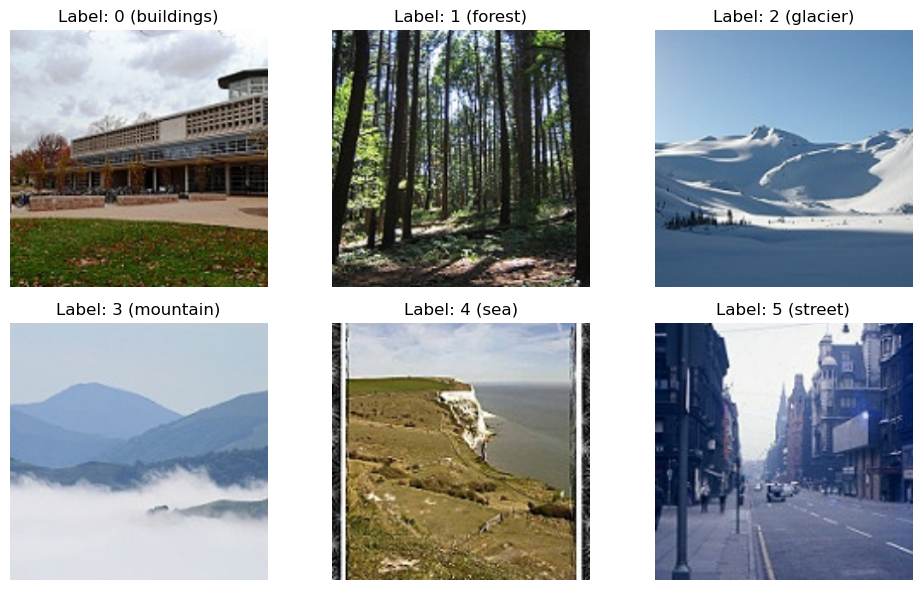

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

index = 0
for i in range(2):
    for j in range(3):
          label = df_images_info['label'][index]
          category = df_images_info['category'][index]
          file_path = os.path.join(root_dir, df_images_info.file_name[index])

          # read an image with OpenCV
          image = cv2.imread(file_path)

          # convert the image to RGB color space.
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # resize image
          image = cv2.resize(image, (256, 256))

          ax[i,j].imshow(image)
          ax[i,j].set_title(f"Label: {label} ({category})")
          ax[i,j].axis('off')
          # add to the index amount of images in category
          index += len(df_images_info[df_images_info['category'] == category])

plt.tight_layout()
plt.show()

## Step 2: prepare the model

Next, we set a baseline. As always, the first step is install and import of necessary libraries.

In [5]:
%%capture
!pip install timm

In [6]:
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

We define the "CustomDataset" class which is used to load and preprocess images from the provided dataset. "CustomDataset" inherits Dataset class from PyTorch.

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df):
          self.root_dir = root_dir
          self.df = df
          self.file_names = df['file_name'].values
          self.labels = df['label'].values

          self.transform = A.Compose([A.Resize(image_size, image_size),
                                      ToTensorV2(),])

    def __len__(self):
          return len(self.df)

    def __getitem__(self, index):# Get sample from dataset
      label = self.labels[index]
      file_path = os.path.join(self.root_dir, self.file_names[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # apply transformation
      transformed = self.transform(image=image)
      image = transformed['image']

      # normalize because ToTensorV2() doesn't normalize the image
      image = image/255

      return image, label

Also we need define two other functions: for training one epoch and for validation one epoch.

In [8]:
def train_one_epoch(dataloader, model, optimizer, scheduler, criterion):
    
  # training mode
  model.train()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):

          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

          # optimize
          loss.backward()
          optimizer.step()

      scheduler.step()

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

In [9]:
def validate_one_epoch(dataloader, model, criterion):
      # validation mode
      model.eval()

      final_y = []
      final_y_pred = []
      final_loss = []

      for step, batch in enumerate(dataloader):
          X = batch[0].to(device)
          y = batch[1].to(device)

          with torch.no_grad():
              y_pred = model(X)

              loss = criterion(y_pred, y)

              # convert y and y_pred to lists
              y =  y.detach().to(device).cpu().numpy().tolist()
              y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

              # extend original list
              final_y.extend(y)
              final_y_pred.extend(y_pred)
              final_loss.append(loss.item())

      # calculate statistics
      loss = np.mean(final_loss)
      final_y_pred = np.argmax(final_y_pred, axis=1)
      metric = accuracy_score(final_y, final_y_pred)

      return metric, loss

As we can see code for training and validation functions are similar. However, mixing them into a single function can make the code more complex and harder to understand. So it's better to keep them separate for better code organization and readability.

Now let's define function which fits the model for all epochs.

In [10]:
# fit model for all epochs
def fit(model, optimizer, scheduler, epochs, criterion,
        train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        acc, loss = train_one_epoch(train_dataloader, model, optimizer,
                                    scheduler, criterion)

        print(f'Train Loss: {loss:.4f} Train Accuracy: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader != None:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model,
                                                   criterion)
            print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

Also we need function for visualisation the results (loss and accuracy).

In [11]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    list_for_plot = [acc, loss, val_acc, val_loss]

    for i in range(2):
      ax[i].plot(range(len(list_for_plot[i])), list_for_plot[i], label = 'train')
      ax[i].plot(range(len(list_for_plot[i+2])), list_for_plot[i+2], label = 'valid')
      ax[i].set_xticks(range(len(loss)), range(len(loss)))
      ax[i].set_xlabel('Epochs')
      ax[i].legend(loc="upper right")
    ax[0].set_title('Metric (Accuracy)')
    ax[1].set_title('Loss')
    plt.show()

Let's define settings of the training process.

In [12]:
image_size = 256
batch_size = 32

# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

n_classes = len(df_images_info.label.unique())
backbone = 'resnet18'

learning_rate = 1e-4

epochs = 5
lr_min = 1e-5

We use the cross-validation strategy for splitting dataset.

In [13]:
# Create a new column for cross-validation folds
df_images_info["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
      df_images_info.loc[val_ , "kfold"] = fold

Let's choose model and run it for each fold of the cross-validation.

We use library with name "timm" to get pre-trained models.
As model, we use a ResNet with 18 layers. ResNet (Residual Network) is a type of convolutional neural network (CNN) using residual blocks.
There are many different models in the ResNet family. We will explore them in the step 3 and select the most suitable architecture for the task.

To train the model, we also need a loss function (criterion), an optimization algorithm (optimizer) and, a learning rate scheduler.

As loss function we will use categorical cross-entropy, which suit well for multi-class classification.

As optimizer, we will use algorithm Adam. Adam is a commonly used optimization algorithm.

We will use cosine decay as a learning rate scheduler for fine-tuning.

Epoch 1/5
Train Loss: 0.7897 Train Accuracy: 0.7785
Validation Loss: 0.2750 Validation Acc: 0.9149
Epoch 2/5
Train Loss: 0.2977 Train Accuracy: 0.9017
Validation Loss: 0.2123 Validation Acc: 0.9280
Epoch 3/5
Train Loss: 0.2293 Train Accuracy: 0.9242
Validation Loss: 0.1929 Validation Acc: 0.9377
Epoch 4/5
Train Loss: 0.2028 Train Accuracy: 0.9295
Validation Loss: 0.1868 Validation Acc: 0.9384
Epoch 5/5
Train Loss: 0.1855 Train Accuracy: 0.9368
Validation Loss: 0.1870 Validation Acc: 0.9401


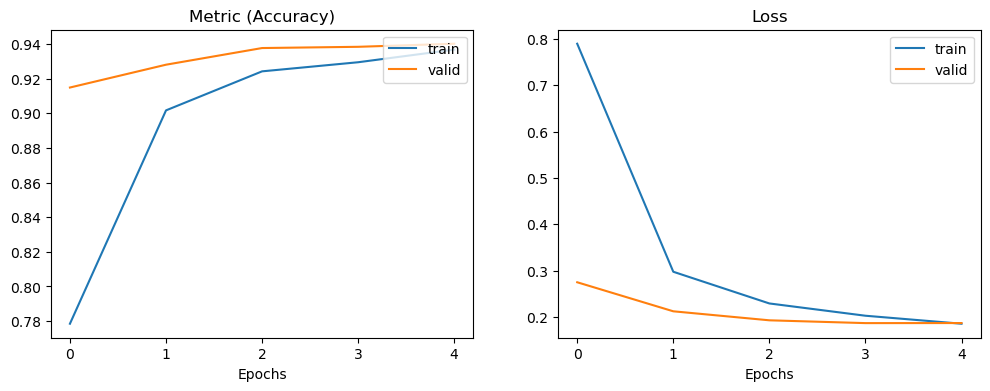

Epoch 1/5
Train Loss: 0.8146 Train Accuracy: 0.7846
Validation Loss: 0.3131 Validation Acc: 0.9024
Epoch 2/5
Train Loss: 0.2885 Train Accuracy: 0.9087
Validation Loss: 0.2363 Validation Acc: 0.9238
Epoch 3/5
Train Loss: 0.2260 Train Accuracy: 0.9254
Validation Loss: 0.2035 Validation Acc: 0.9302
Epoch 4/5
Train Loss: 0.1901 Train Accuracy: 0.9352
Validation Loss: 0.1971 Validation Acc: 0.9295
Epoch 5/5
Train Loss: 0.1738 Train Accuracy: 0.9432
Validation Loss: 0.1955 Validation Acc: 0.9327


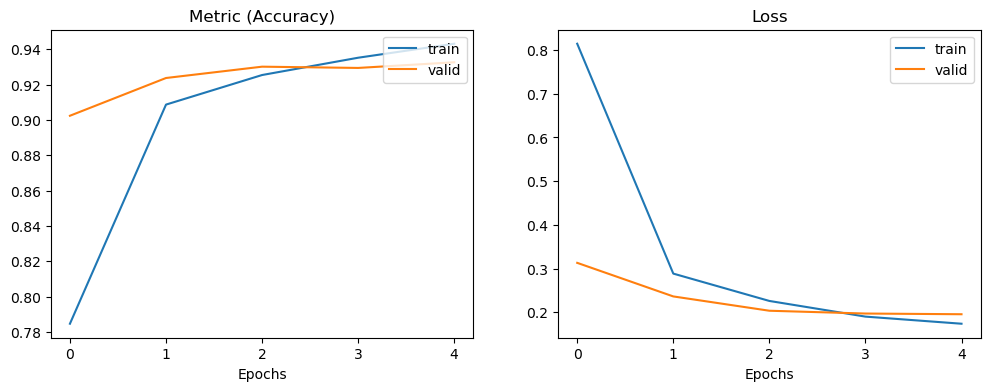

Epoch 1/5
Train Loss: 0.8117 Train Accuracy: 0.7841
Validation Loss: 0.3035 Validation Acc: 0.9045
Epoch 2/5
Train Loss: 0.2841 Train Accuracy: 0.9108
Validation Loss: 0.2317 Validation Acc: 0.9206
Epoch 3/5
Train Loss: 0.2233 Train Accuracy: 0.9267
Validation Loss: 0.2102 Validation Acc: 0.9230
Epoch 4/5
Train Loss: 0.1910 Train Accuracy: 0.9375
Validation Loss: 0.2056 Validation Acc: 0.9259
Epoch 5/5
Train Loss: 0.1773 Train Accuracy: 0.9414
Validation Loss: 0.2022 Validation Acc: 0.9270


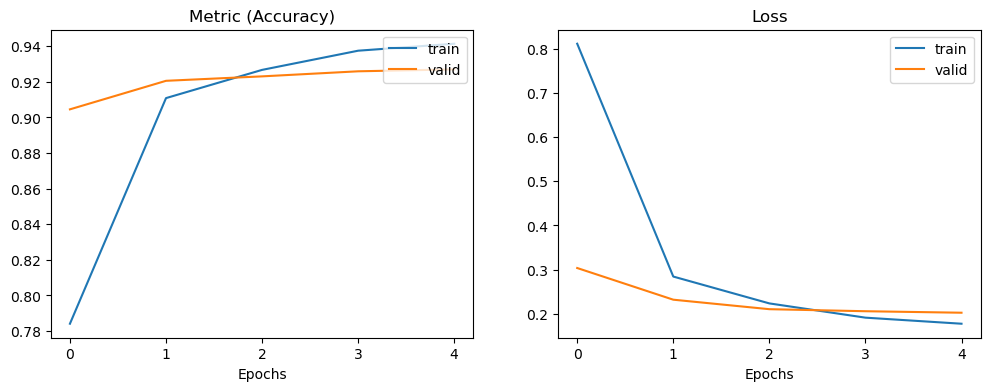

Epoch 1/5
Train Loss: 0.8201 Train Accuracy: 0.7763
Validation Loss: 0.3086 Validation Acc: 0.9024
Epoch 2/5
Train Loss: 0.2853 Train Accuracy: 0.9087
Validation Loss: 0.2323 Validation Acc: 0.9198
Epoch 3/5
Train Loss: 0.2242 Train Accuracy: 0.9270
Validation Loss: 0.2143 Validation Acc: 0.9248
Epoch 4/5
Train Loss: 0.1954 Train Accuracy: 0.9352
Validation Loss: 0.2071 Validation Acc: 0.9259
Epoch 5/5
Train Loss: 0.1757 Train Accuracy: 0.9434
Validation Loss: 0.2022 Validation Acc: 0.9277


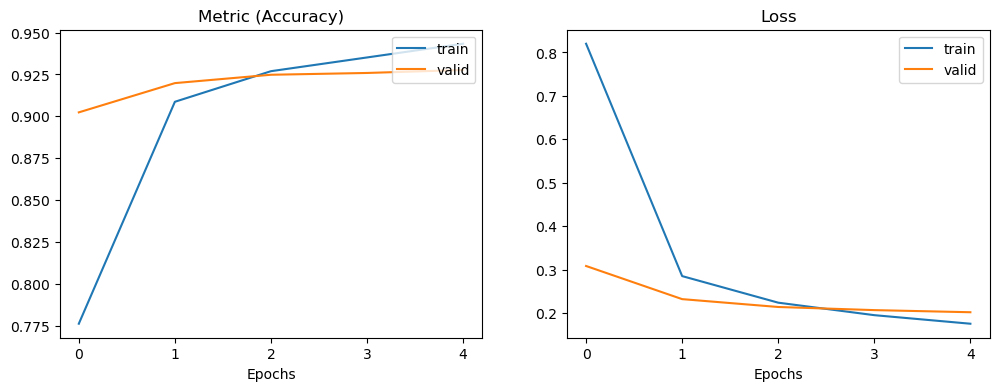

Epoch 1/5
Train Loss: 0.8203 Train Accuracy: 0.7622
Validation Loss: 0.3072 Validation Acc: 0.9059
Epoch 2/5
Train Loss: 0.2873 Train Accuracy: 0.9090
Validation Loss: 0.2332 Validation Acc: 0.9212
Epoch 3/5
Train Loss: 0.2190 Train Accuracy: 0.9287
Validation Loss: 0.2158 Validation Acc: 0.9255
Epoch 4/5
Train Loss: 0.1877 Train Accuracy: 0.9389
Validation Loss: 0.2106 Validation Acc: 0.9287
Epoch 5/5
Train Loss: 0.1718 Train Accuracy: 0.9465
Validation Loss: 0.2092 Validation Acc: 0.9298


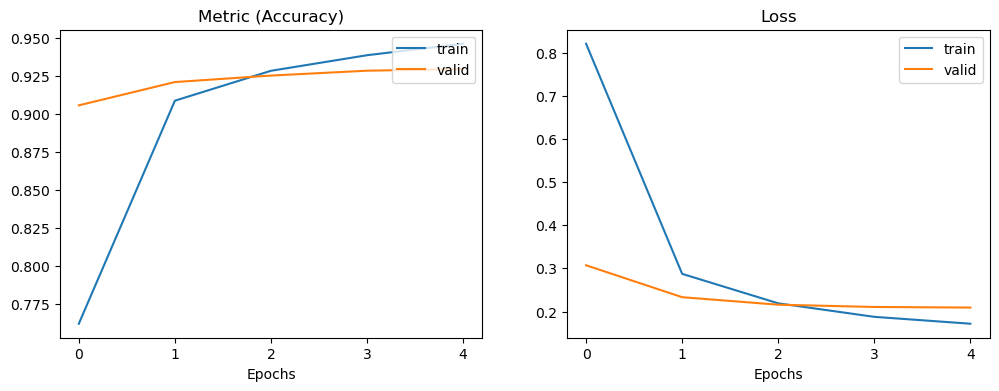

In [22]:
for fold in range(n_folds):
  train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
  valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

  train_dataset = CustomDataset(train_df)
  valid_dataset = CustomDataset(valid_df)

  train_dataloader = DataLoader(train_dataset,
                      batch_size = batch_size,
                      shuffle = True)
  valid_dataloader = DataLoader(valid_dataset,
                      batch_size = batch_size,
                      shuffle = False)


  model = timm.create_model(backbone,
                      pretrained = True,
                      num_classes = n_classes)

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.Adam(model.parameters(),
                        lr = learning_rate,
                        weight_decay = 0,)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                         eta_min=lr_min)

  acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, epochs,
                                            criterion, train_dataloader, valid_dataloader)

  visualize_history(acc, loss, val_acc, val_loss)


## Step 3: run expirements

Now let's run some experiments, we will start by changing the following parameters:

1. epochs: from 2 to 10
2. image size: from 128 to 512
3. backbone: different models from the ResNet family

However before we need create a function for making this process easier.

In [14]:
# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def run_expirement(epochs, learning_rate, image_size, backbone, df_images_info):
  batch_size = 32

  n_folds = 3

  n_classes = len(df_images_info.label.unique())

  lr_min = 1e-5

  acc_list = []
  loss_list = []
  val_acc_list = []
  val_loss_list = []

  # Create a new column for cross-validation folds
  df_images_info["kfold"] = -1

  # Initialize the kfold class
  skf = StratifiedKFold(n_splits=n_folds)

  # Fill the new column
  for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
        df_images_info.loc[val_ , "kfold"] = fold

  for fold in range(n_folds):
    train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
    valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(train_df)
    valid_dataset = CustomDataset(valid_df)

    train_dataloader = DataLoader(train_dataset,
                        batch_size = batch_size,
                        shuffle = True)
    valid_dataloader = DataLoader(valid_dataset,
                        batch_size = batch_size,
                        shuffle = False)


    model = timm.create_model(backbone,
                        pretrained = True,
                        num_classes = n_classes)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.Adam(model.parameters(),
                          lr = learning_rate,
                          weight_decay = 0,)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                          T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                          eta_min=lr_min)

    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler,
                                              epochs, criterion, train_dataloader, valid_dataloader)
    acc_list += acc
    loss_list += loss
    val_acc_list += val_acc
    val_loss_list += val_loss
  return acc_list, loss_list, val_acc_list, val_loss_list


In [18]:
expirements_list = []
backbone_list = ["resnet18", "resnet34", "resnet50", "resnet101"]
learning_rate = 0.0001
num_epochs = 5

for backbone_model in backbone_list:
  print(backbone_model)
  acc, loss, val_acc, val_loss = run_expirement(num_epochs, learning_rate,
                                                      image_size, backbone_model, df_images_info)
  mean_val_acc = sum(val_acc)/len(val_acc)
  mean_val_loss = sum(val_loss)/len(val_loss)
  expirements_list.append((backbone_model, learning_rate, image_size, num_epochs,
                          mean_val_acc, mean_val_loss))

resnet18
Epoch 1/5
Train Loss: 0.8954 Train Accuracy: 0.7536
Validation Loss: 0.3414 Validation Acc: 0.8972
Epoch 2/5
Train Loss: 0.3158 Train Accuracy: 0.8999
Validation Loss: 0.2198 Validation Acc: 0.9312
Epoch 3/5
Train Loss: 0.2413 Train Accuracy: 0.9223
Validation Loss: 0.2010 Validation Acc: 0.9339
Epoch 4/5
Train Loss: 0.2079 Train Accuracy: 0.9319
Validation Loss: 0.1941 Validation Acc: 0.9369
Epoch 5/5
Train Loss: 0.1893 Train Accuracy: 0.9372
Validation Loss: 0.1936 Validation Acc: 0.9352
Epoch 1/5
Train Loss: 0.8979 Train Accuracy: 0.7564
Validation Loss: 0.3378 Validation Acc: 0.8965
Epoch 2/5
Train Loss: 0.3078 Train Accuracy: 0.9005
Validation Loss: 0.2397 Validation Acc: 0.9179
Epoch 3/5
Train Loss: 0.2357 Train Accuracy: 0.9221
Validation Loss: 0.2182 Validation Acc: 0.9250
Epoch 4/5
Train Loss: 0.1947 Train Accuracy: 0.9378
Validation Loss: 0.2108 Validation Acc: 0.9237
Epoch 5/5
Train Loss: 0.1894 Train Accuracy: 0.9382
Validation Loss: 0.2052 Validation Acc: 0.9280
E

Epoch 1/5
Train Loss: 0.9640 Train Accuracy: 0.7413
Validation Loss: 0.3103 Validation Acc: 0.9149
Epoch 2/5
Train Loss: 0.3038 Train Accuracy: 0.9043
Validation Loss: 0.2212 Validation Acc: 0.9280
Epoch 3/5
Train Loss: 0.2233 Train Accuracy: 0.9270
Validation Loss: 0.1905 Validation Acc: 0.9391
Epoch 4/5
Train Loss: 0.1868 Train Accuracy: 0.9381
Validation Loss: 0.1913 Validation Acc: 0.9354
Epoch 5/5
Train Loss: 0.1624 Train Accuracy: 0.9487
Validation Loss: 0.1882 Validation Acc: 0.9372
Epoch 1/5
Train Loss: 0.9336 Train Accuracy: 0.7449
Validation Loss: 0.3320 Validation Acc: 0.8993
Epoch 2/5
Train Loss: 0.2984 Train Accuracy: 0.9087
Validation Loss: 0.2371 Validation Acc: 0.9222
Epoch 3/5
Train Loss: 0.2217 Train Accuracy: 0.9277
Validation Loss: 0.2187 Validation Acc: 0.9271
Epoch 4/5
Train Loss: 0.1910 Train Accuracy: 0.9375
Validation Loss: 0.2083 Validation Acc: 0.9256
Epoch 5/5
Train Loss: 0.1710 Train Accuracy: 0.9448
Validation Loss: 0.2076 Validation Acc: 0.9277
Epoch 1/5


Epoch 1/5
Train Loss: 0.8971 Train Accuracy: 0.7674
Validation Loss: 0.2619 Validation Acc: 0.9153
Epoch 2/5
Train Loss: 0.2755 Train Accuracy: 0.9056
Validation Loss: 0.1971 Validation Acc: 0.9342
Epoch 3/5
Train Loss: 0.2023 Train Accuracy: 0.9312
Validation Loss: 0.1832 Validation Acc: 0.9391
Epoch 4/5
Train Loss: 0.1678 Train Accuracy: 0.9415
Validation Loss: 0.1825 Validation Acc: 0.9372
Epoch 5/5
Train Loss: 0.1438 Train Accuracy: 0.9541
Validation Loss: 0.1816 Validation Acc: 0.9382
Epoch 1/5
Train Loss: 0.8954 Train Accuracy: 0.7522
Validation Loss: 0.2715 Validation Acc: 0.9113
Epoch 2/5
Train Loss: 0.2664 Train Accuracy: 0.9151
Validation Loss: 0.2108 Validation Acc: 0.9250
Epoch 3/5
Train Loss: 0.2057 Train Accuracy: 0.9326
Validation Loss: 0.1990 Validation Acc: 0.9277
Epoch 4/5
Train Loss: 0.1597 Train Accuracy: 0.9479
Validation Loss: 0.1943 Validation Acc: 0.9314
Epoch 5/5
Train Loss: 0.1441 Train Accuracy: 0.9539
Validation Loss: 0.1925 Validation Acc: 0.9299
Epoch 1/5


Epoch 1/5
Train Loss: 0.8489 Train Accuracy: 0.7420
Validation Loss: 0.2449 Validation Acc: 0.9168
Epoch 2/5
Train Loss: 0.2501 Train Accuracy: 0.9121
Validation Loss: 0.1886 Validation Acc: 0.9357
Epoch 3/5
Train Loss: 0.1860 Train Accuracy: 0.9343
Validation Loss: 0.1760 Validation Acc: 0.9393
Epoch 4/5
Train Loss: 0.1491 Train Accuracy: 0.9482
Validation Loss: 0.1734 Validation Acc: 0.9401
Epoch 5/5
Train Loss: 0.1199 Train Accuracy: 0.9612
Validation Loss: 0.1734 Validation Acc: 0.9406
Epoch 1/5
Train Loss: 0.9009 Train Accuracy: 0.7249
Validation Loss: 0.2956 Validation Acc: 0.8927
Epoch 2/5
Train Loss: 0.2793 Train Accuracy: 0.8993
Validation Loss: 0.2473 Validation Acc: 0.9115
Epoch 3/5
Train Loss: 0.2139 Train Accuracy: 0.9240
Validation Loss: 0.2309 Validation Acc: 0.9160
Epoch 4/5
Train Loss: 0.1759 Train Accuracy: 0.9383
Validation Loss: 0.2254 Validation Acc: 0.9194
Epoch 5/5
Train Loss: 0.1652 Train Accuracy: 0.9424
Validation Loss: 0.2220 Validation Acc: 0.9218
Epoch 1/5


In [19]:
df_expirements = pd.DataFrame(expirements_list,
                              columns=['backbone', 'learning_rate',
                                       'image_size', 'number_of_epochs',
                                       'validation_accuracy', 'validation_loss'])
df_expirements.head()

,backbone,learning_rate,image_size,number_of_epochs,validation_accuracy,validation_loss
0,resnet18,0.0001,256,5,0.922075,0.240083
1,resnet34,0.0001,256,5,0.925581,0.230410
2,resnet50,0.0001,256,5,0.928388,0.211406
3,resnet101,0.0001,256,5,0.920778,0.225062
